# Bayesian neural network
In this notebook, we make use of HMC to estimate the posterior predictive distribution over the rotating MNIST dataset with missing rotations, which we call _trenches_.

In [1]:
import jax
import distrax
import numpy as np
import pandas as pd
import jax.numpy as jnp
import flax.linen as nn
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Callable
from dynamax.utils import datasets
from dynamax.rebayes import hamiltonian_monte_carlo as hmc

%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

In [2]:
key = jax.random.PRNGKey(314)
key_init, key_train = jax.random.split(key)
key_warmup, key_train = jax.random.split(key_train)

In [3]:
class MLP(nn.Module):
    dim_out: int
    dim_hidden: int = 100
    activation: Callable = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(100)(x)
        x = self.activation(x)
        x = nn.Dense(50)(x)
        x = self.activation(x)
        x = nn.Dense(10)(x)
        x = self.activation(x)
        x = nn.Dense(10)(x)
        x = self.activation(x)
        x = nn.Dense(self.dim_out)(x)
        return x

# Rotating MNIST

In [4]:
np.random.seed(314)
train, test = datasets.load_rotated_mnist(target_digit=2)
X_train, y_train = train
X_test, y_test = test

X_train = jnp.array(X_train)
y_train = jnp.array(y_train)

X_test = jnp.array(X_test)
y_test = jnp.array(y_test)

num_train, dim_input = X_train.shape

In [5]:
batch_size = 100
batch = (batch_size, dim_input)
model = MLP(1, dim_hidden=200, activation=nn.elu)
batch = jnp.ones(batch)

params_init = model.init(key_init, batch)
priors = hmc.PriorParam(scale_obs=2.0, scale_weight=1/2)

In [6]:
%%time
num_eval = 2000
num_warmup = 200
num_steps = 100

X_eval = X_train[:num_eval]
y_eval = y_train[:num_eval]

states = hmc.inference(
    key, model.apply, hmc.log_joint, params_init, priors, X_eval, y_eval,
    num_warmup, num_steps
)

sampled_params = jax.block_until_ready(states.position)

CPU times: user 26.4 s, sys: 465 ms, total: 26.9 s
Wall time: 1min 55s


## Evaluation metrics

In [7]:
yhat_samples = jax.vmap(model.apply, (0, None))(sampled_params, X_test).squeeze()
yhat_train_samples = jax.vmap(model.apply, (0, None))(sampled_params, X_train).squeeze()

### Mean absolute error

In [8]:
yhat_test = yhat_samples.mean(axis=0)
metric_mae = jnp.abs(yhat_test - y_test).mean()
metric_mae

Array(7.6253886, dtype=float32)

In [9]:
metric_rmse = jnp.sqrt(jnp.power(yhat_test - y_test, 2).mean())
metric_rmse

Array(13.717394, dtype=float32)

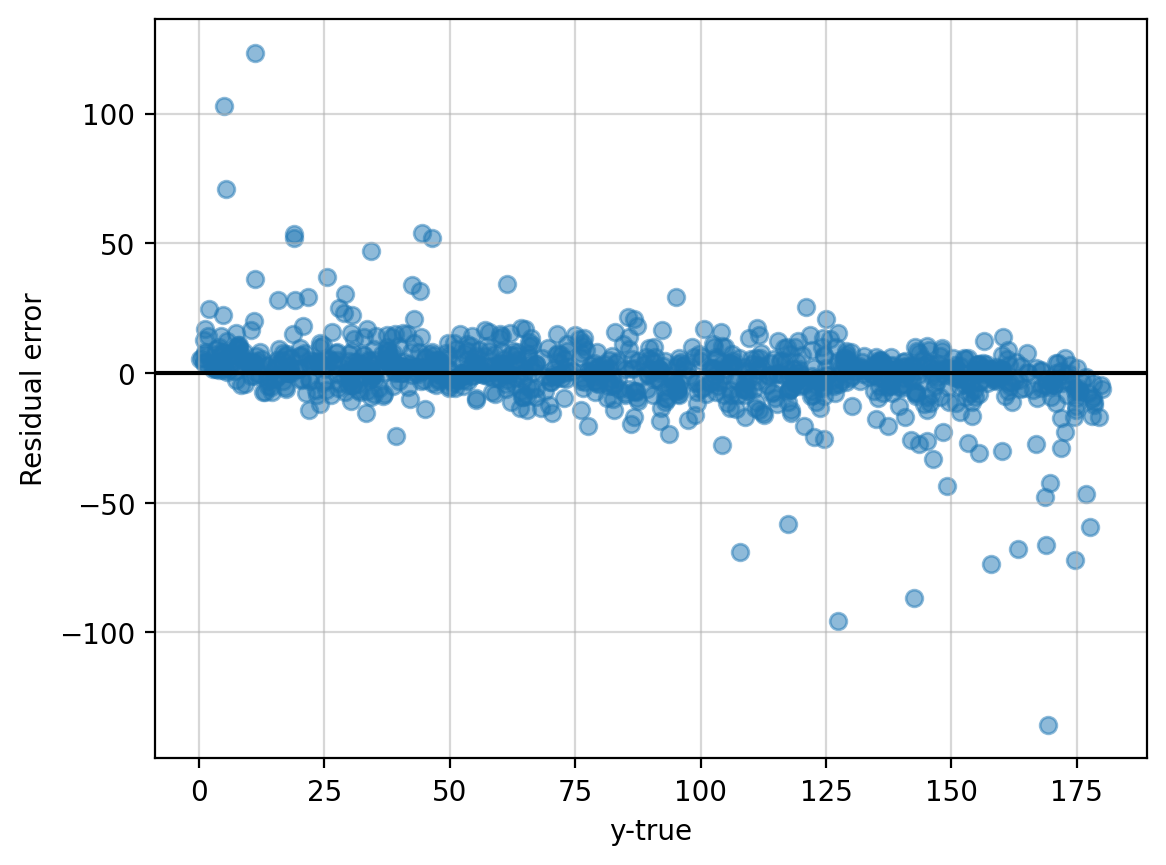

In [10]:
residual_err = yhat_test - y_test
plt.scatter(y_test, residual_err, alpha=0.5, edgecolors=None)
plt.ylabel("Residual error")
plt.xlabel("y-true")
plt.axhline(y=0, c="black")
plt.grid(alpha=0.5)

### Negative marginal log-likelihood

The marginal log-likelihood can be approximated as
$$
\begin{aligned}
    \log p(y \vert x, \cal D)
    &= \log\int p({\bf w} \vert \cal D) p(y \vert x, {\bf w}) d{\bf w}\\
    &= \log \mathbb{E}_{p({\bf w}\vert \cal D)}[p(y \vert x, {\bf w})] \\
    &\leq \mathbb{E}_{p({\bf w}\vert \cal D)}[\log p(y \vert x, {\bf w})] \\
    &\approx \frac{1}{S}\sum_{s=1}^S\log p\left(y \vert x, {\bf w}^{(s)}\right); {\bf w}^{(s)} \sim p(\cdot \vert \cal D)
\end{aligned} 
$$

In [11]:
means = yhat_samples.mean(axis=0).sum()
nll = -distrax.Normal(means, priors.scale_obs).log_prob(y_test).mean()
nll

Array(1.01997594e+09, dtype=float32)

## The trenches

1. $[0, 45] \cup [90, 135]$

In [12]:
map_trench_1 = (y_train  >= 0) & (y_train <= 45)
map_trench_2 = (y_train >= 90) & (y_train <= 135)
map_trench = map_trench_1 | map_trench_2

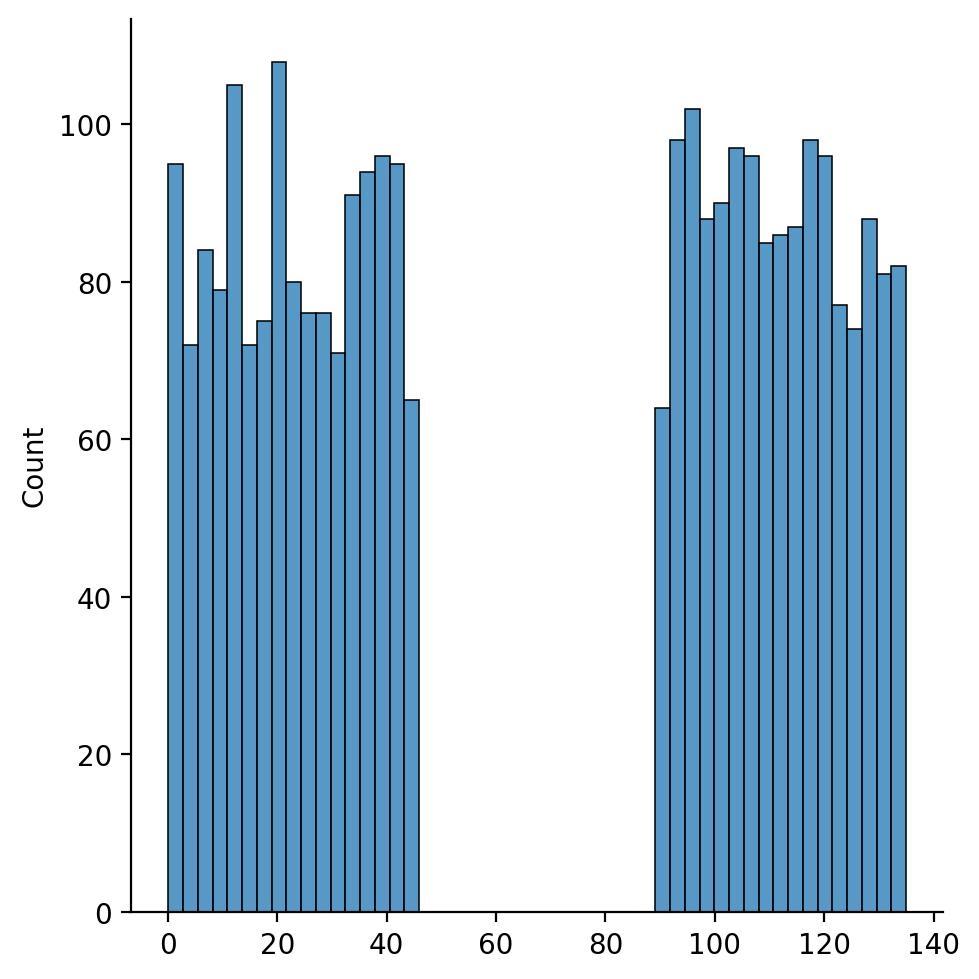

In [13]:
y_eval = y_train[map_trench]
X_eval = X_train[map_trench]
sns.displot(y_eval, bins=50)

In [14]:
%%time
states = hmc.inference(
    key, model.apply, hmc.log_joint, params_init, priors, X_eval, y_eval,
    num_warmup, num_steps
)

sampled_params = jax.block_until_ready(states.position)

CPU times: user 25.7 s, sys: 578 ms, total: 26.3 s
Wall time: 2min 33s


## Evaluation metrics

In [15]:
yhat_samples = jax.vmap(model.apply, (0, None))(sampled_params, X_test).squeeze()
yhat_train_samples = jax.vmap(model.apply, (0, None))(sampled_params, X_train).squeeze()

### Mean absolute error

In [16]:
yhat_test = yhat_samples.mean(axis=0)
metric_mae = jnp.abs(yhat_test - y_test).mean()
metric_mae

Array(19.076, dtype=float32)

In [17]:
metric_rmse = jnp.sqrt(jnp.power(yhat_test - y_test, 2).mean())
metric_rmse

Array(34.927677, dtype=float32)

In [18]:
xtrench1 = jnp.linspace(45, 90, 100)
xtrench2 = jnp.linspace(135, 180, 100)

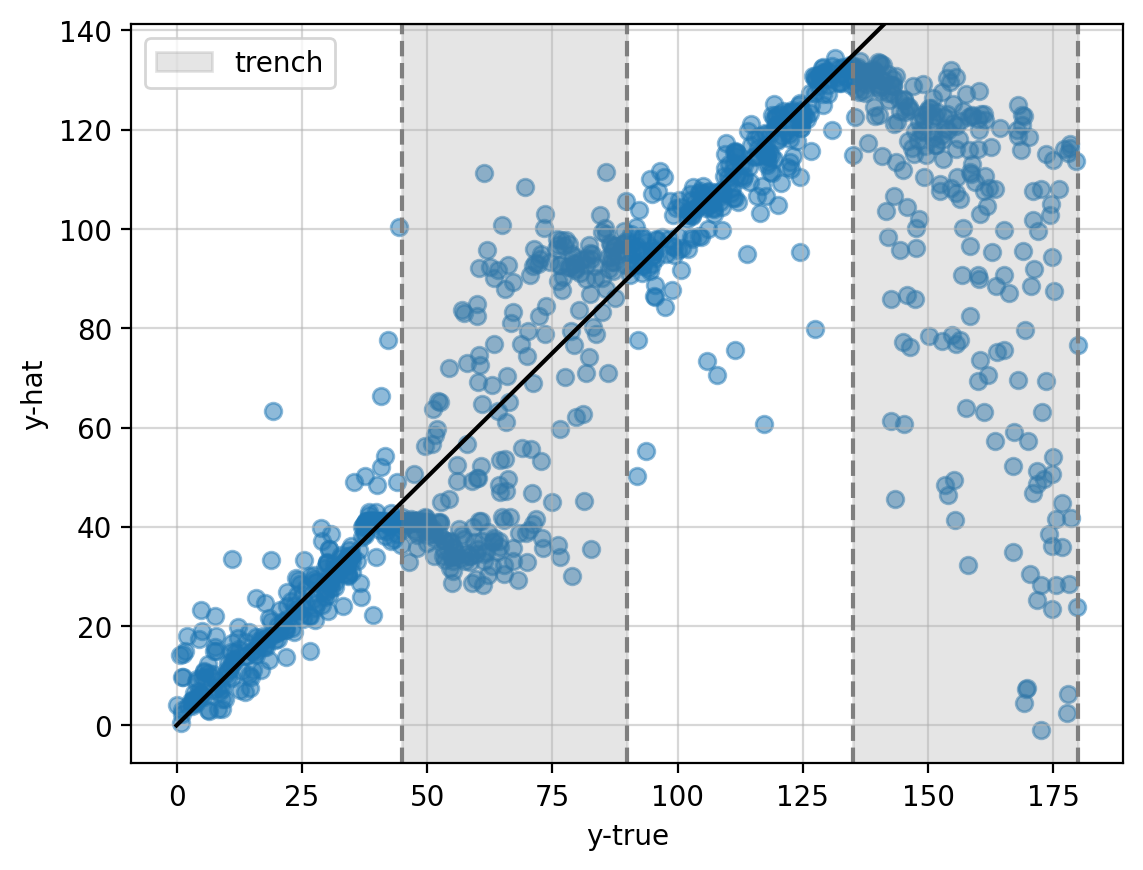

In [19]:
residual_err = yhat_test
plt.scatter(y_test, residual_err, alpha=0.5, edgecolors=None)
plt.ylabel("y-hat")
plt.xlabel("y-true")

# Trenches
ymin, ymax = plt.ylim()

plt.axvline(x=45, c="tab:gray", linestyle="--")
plt.axvline(x=90, c="tab:gray", linestyle="--")
plt.fill_between(xtrench1, ymax, ymin, alpha=0.2, color="tab:gray", label="trench")

plt.axvline(x=135, c="tab:gray", linestyle="--")
plt.axvline(x=180, c="tab:gray", linestyle="--")
plt.fill_between(xtrench2, ymax, ymin, alpha=0.2, color="tab:gray")

# plt.axhline(y=0, c="black")
plt.plot([0, 180], [0, 180], c="black")

plt.ylim(ymin, ymax)
plt.legend()
plt.grid(alpha=0.5)

In [20]:
n_rotations = 181
rotations = np.linspace(0, 180, n_rotations)

# group_ix = jnp.digitize(yhat_test, rotations)
group_ix = jnp.digitize(y_test, rotations)

summary_est = pd.DataFrame({
    "y_hat": np.array(yhat_test),
    "group": np.array(group_ix),
}).groupby("group").mean()


summary_est_std = pd.DataFrame({
    "y_hat_std": np.array(yhat_test),
    "group": np.array(group_ix),
}).groupby("group").std()


summary_true = pd.DataFrame({
    "y_true": np.array(y_test),
    "group": np.array(group_ix),
}).groupby("group").mean()

summary = summary_true.join(summary_est).join(summary_est_std)

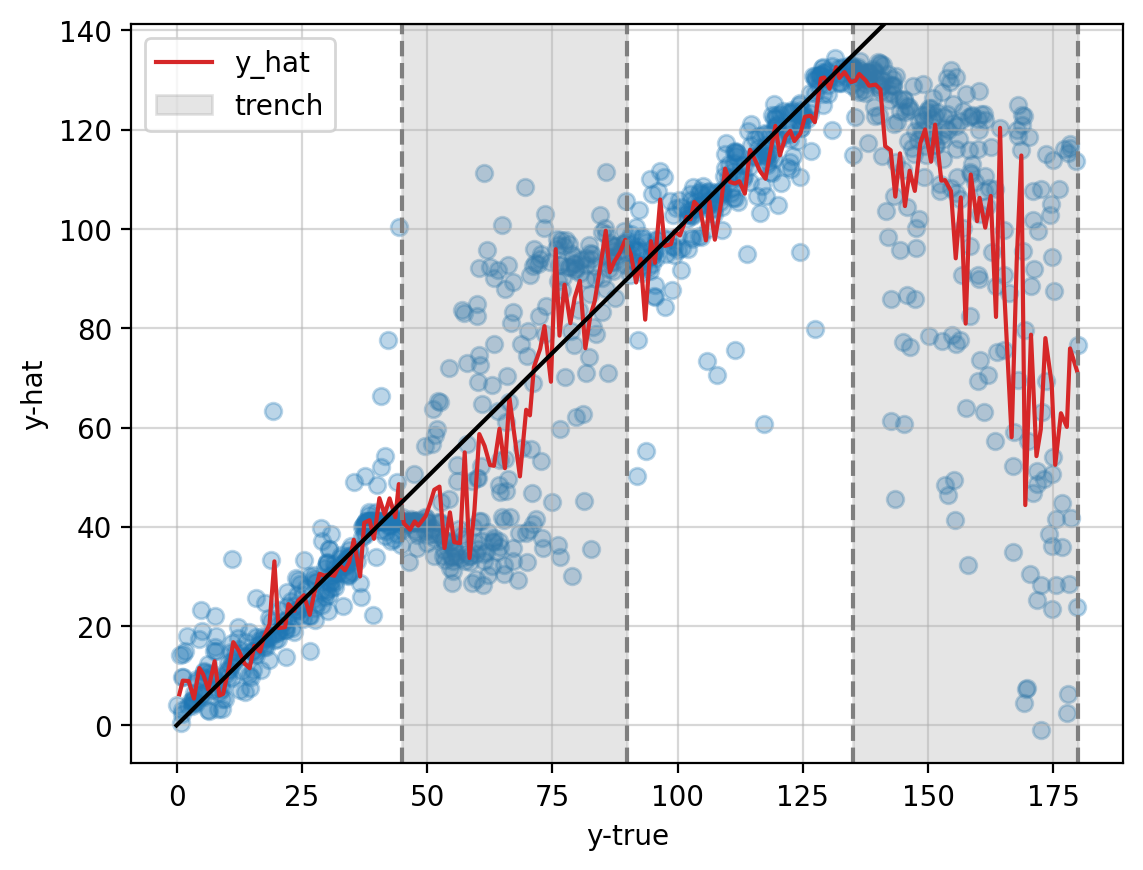

In [21]:
residual_err = yhat_test
fig, ax = plt.subplots()

summary.plot(x="y_true", y="y_hat", ax=ax, c="tab:red")

plt.scatter(y_test, residual_err, alpha=0.3, edgecolors=None)
plt.ylabel("y-hat")
plt.xlabel("y-true")

# Trenches
ymin, ymax = plt.ylim()

plt.axvline(x=45, c="tab:gray", linestyle="--")
plt.axvline(x=90, c="tab:gray", linestyle="--")
plt.fill_between(xtrench1, ymax, ymin, alpha=0.2, color="tab:gray", label="trench")

plt.axvline(x=135, c="tab:gray", linestyle="--")
plt.axvline(x=180, c="tab:gray", linestyle="--")
plt.fill_between(xtrench2, ymax, ymin, alpha=0.2, color="tab:gray")

# plt.axhline(y=0, c="black")
plt.plot([0, 180], [0, 180], c="black")

plt.ylim(ymin, ymax)
plt.legend()
plt.grid(alpha=0.5)

### Evaluating the posterior predictive as a function of rotation angle

In [22]:
ix_target = 0
x_target = np.array(X_eval[ix_target]).reshape(28, 28)
y_init = float(y_eval[ix_target].item())
x_target = datasets.rotate_mnist(x_target, -y_init).ravel()

We consider the same image rotated from 0 to 180 degrees

In [23]:
n_rotations = 300
rotations = np.linspace(0, 180, n_rotations)

In [24]:
def generate_rotated_images(images, angles, n_processes=1):
    n_configs = len(images)
    processer = datasets.DataAugmentationFactory(datasets.rotate_mnist)
    configs = [{"angle": float(angle)} for angle in angles]
    images_proc = processer(images, configs, n_processes=n_processes)
    return images_proc, angles

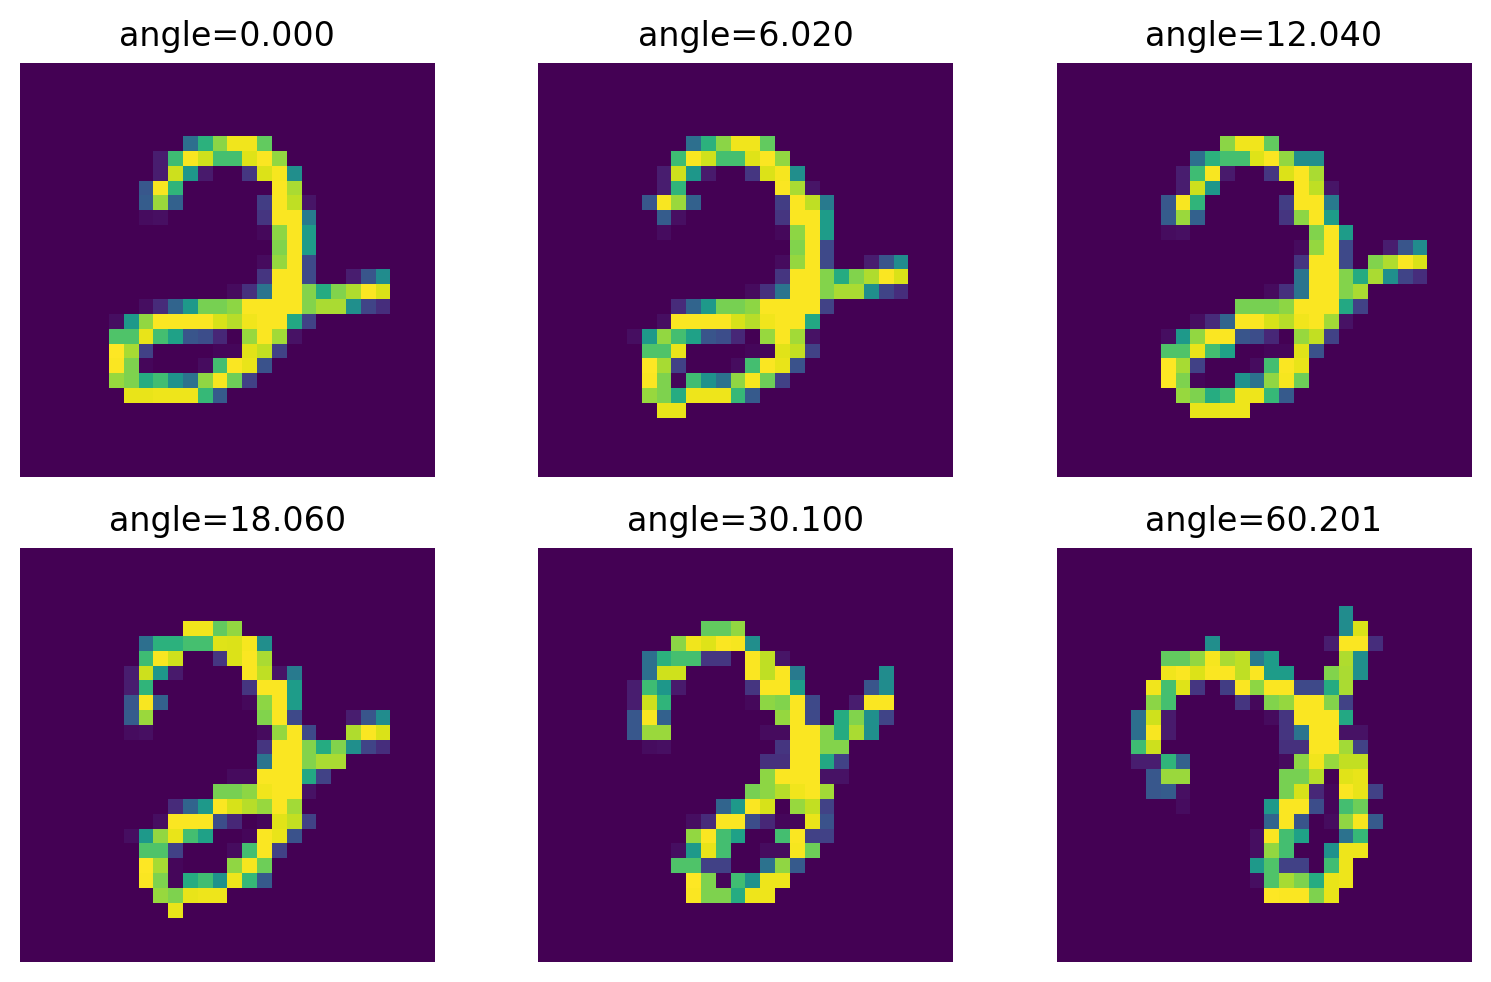

In [25]:
X_target = x_target[None, :] * jnp.ones(n_rotations)[..., None]
X_target = np.array(X_target.reshape(-1, 28, 28))
X_target, y_target = generate_rotated_images(X_target, rotations)

X_target = X_target.reshape(-1, 28 ** 2)

ixs = [0, 10, 20, 30, 50, 100, 180]

fig, axs = plt.subplots(2, 3, figsize=(8, 5))
axs = axs.ravel()
for ax, ix in zip(axs, ixs):
    ax.imshow(X_target[ix].reshape(28, 28))
    ax.axis("off")
    angle = y_target[ix]
    ax.set_title(f"{angle=:0.3f}")
plt.tight_layout()

# To TPU
X_target = jnp.array(X_target)
y_target = jnp.array(y_target)

In [26]:
%%time
yhat_samples = jax.vmap(model.apply, (0, None))(sampled_params, X_target).squeeze()

CPU times: user 4.84 s, sys: 12.5 ms, total: 4.85 s
Wall time: 3.82 s


In [27]:
yhat_mean = yhat_samples.mean(axis=0)
yhat_std = yhat_samples.std(axis=0)

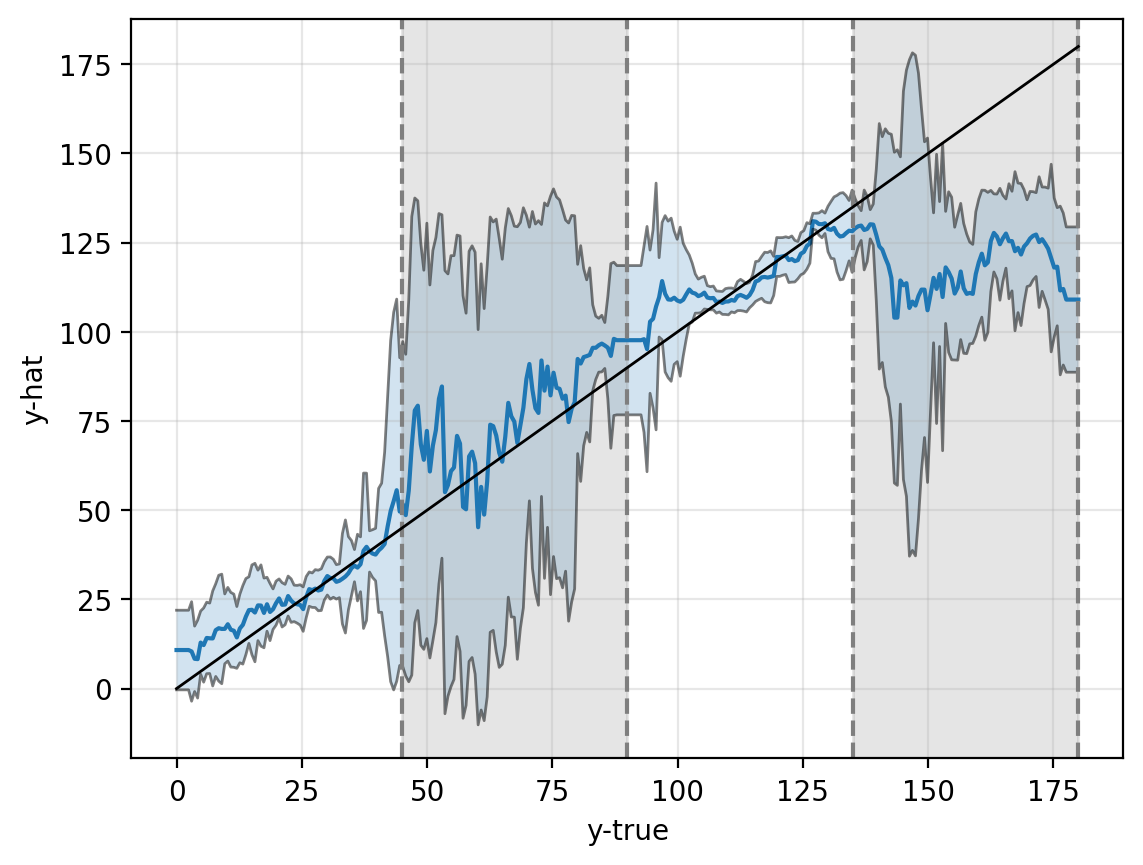

In [28]:
plt.plot(y_target, yhat_mean)

lbound = yhat_mean - 1.96 * yhat_std
ubound = yhat_mean + 1.96 * yhat_std
plt.fill_between(y_target, lbound, ubound, alpha=0.2)
plt.plot(y_target, lbound, c="black", linewidth=1, alpha=0.5)
plt.plot(y_target, ubound, c="black", linewidth=1, alpha=0.5)

plt.xlabel("y-true")
plt.ylabel("y-hat")

ymin, ymax  = plt.ylim()


plt.axvline(x=45, c="tab:gray", linestyle="--")
plt.axvline(x=90, c="tab:gray", linestyle="--")
plt.fill_between(xtrench1, ymax, ymin, alpha=0.2, color="tab:gray", label="trench")

plt.axvline(x=135, c="tab:gray", linestyle="--")
plt.axvline(x=180, c="tab:gray", linestyle="--")
plt.fill_between(xtrench2, ymax, ymin, alpha=0.2, color="tab:gray")

plt.plot([0, 180], [0, 180], c="black", linewidth=1)
plt.ylim(ymin, ymax)
plt.grid(alpha=0.3)